# Definición del problema a resolver
• ¿Cuál es el problema?
- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

• Acción que buscamos hacer para solucionar el problema

• ¿Cuáles son las variables disponibles?

• ¿En qué momento se va a implantar el modelo? ¿Qué variables hay disponibles en
el momento de llamada al modelo?

• ¿Cómo se va a validar el modelo?


Aquí hay que redactar una introducción explicando el caso y toda la parafernalia...

# Exploración general / inicial
• Dimensiones de la tabla y variables

• Analizar si las variables estarán disponibles en el momento de la llamada al modelo
(sino se estaría introduciendo información a futuro en el modelo)

• Exploración de la variable objetivo

• Rápido análisis de valores nulos

• Se explora el número de variables numéricas y categóricas y se decide qué proceso
realizar para tratarlas

• Transformaciones iniciales de algunas variables: formato de fechas, eliminar
espacios de una variable string, etc

• Analizar la variable objetivo: aislándola de las demás variables (quizás, a pesar de
no tener en cuenta las variables tenemos que sacar un 80% de accuracy.

In [1]:
#Librerías
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import plotly.express as px
import scipy.stats as ss

In [2]:
#Importamos los datos
df = pd.read_csv("../data/NCDB_1999_to_2014.csv")

C:\Users\atell\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,2,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print("El dataset está compuesto por", len(df.index), "filas y", len(df.columns), "columnas")
df.head(5)

El dataset está compuesto por 5860405 filas y 22 columnas


,C_YEAR,C_MNTH,C_WDAY,C_HOUR,C_SEV,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,...,V_ID,V_TYPE,V_YEAR,P_ID,P_SEX,P_AGE,P_PSN,P_ISEV,P_SAFE,P_USER
0,1999,1,1,20,2,02,34,UU,1,5,...,01,06,1990,01,M,41,11,1,UU,1
1,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,01,M,19,11,1,UU,1
2,1999,1,1,20,2,02,34,UU,1,5,...,02,01,1987,02,F,20,13,2,02,2
3,1999,1,1,08,2,01,01,UU,5,3,...,01,01,1986,01,M,46,11,1,UU,1
4,1999,1,1,08,2,01,01,UU,5,3,...,99,NN,NNNN,01,M,05,99,2,UU,3


In [4]:
# Cambio de nombre de las variables
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(df.columns))

df.columns = new_names

True


In [5]:
# Comprobamos el tipo de las variables, la mayoría son categóricas salvo fechas y variable objetivo(booleana)
# Algunas variables las podemos convertir en numéricas. ej. passenger_age
print(df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index())
df.dtypes 

  feature_type  count
0        int64      2
1       object     20


year                   int64
month                 object
weekday               object
hour                  object
fatality               int64
vehicles_involved     object
crash_type            object
crash_place           object
crash_weather         object
surface_state         object
road_slope            object
traffic_state         object
vehicle_id            object
vehicle_type          object
vehicle_year          object
passenger_id          object
passenger_sex         object
passenger_age         object
passenger_role        object
passenger_fatality    object
passenger_safety      object
passenger_type        object
dtype: object

# Variables futuras y duplicados

El dataset contiene variables que no están disponible en el momento de la colisión y por tanto escapan al objetivo de nuestro ánalisis y otras que directamente no son de útilidad como IDs. También debemos prescindir de registros duplicados antes de eliminar los IDs

In [6]:
print(df.shape)
df = df.drop_duplicates().drop(["passenger_id","passenger_fatality"], axis=1)
df.shape

(5860405, 22)


(5855336, 20)

# Variable Objetivo

In [7]:
# Recodeado de la variable objetivo
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality
df['fatality'] = df['fatality'].replace({2:0})

In [8]:
#Ponemos la variable objetivo a la derecha del dataframe
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])
df = df[new_columns]

In [9]:
# Plot variable 'fatality. Podemos ver que el dataset está muy desbalanceado
fatality_per = df['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = df['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

# Valores Nulos

En el diccionario de datos encontramos varios tipos de datos ausentes.  Principalmente U, UU y UUUU que son datos estirctamente desconocidos.  
Luego tenemos los X, XX y XXXX que son no proporcionados por la jurisdicción, no encontramos ningun registro con esta etiqueta en los datos.  
Por otro lado tenemos los N, NN y NNNN que hacen referencia a que la variable no aplica al registro concreto. Por ejemplo en los registros creados para coches aparcados y peatones.  Más adelante decidiremos que hacer con estos registros.  
Por último los Q, QQ, QQQQ que son otras opciones que no aparecen en las posibles y tampoco deben ser tratados como nulos.

In [10]:
# Remplazamos U, UU y UUUU por NAs
df = df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [11]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

,index,missing_value,feature_type,columns_percentage
19,passenger_safety,614507,object,0.104948
18,crash_place,504547,object,0.086169
17,road_slope,434626,object,0.074227
16,passenger_age,376225,object,0.064253
15,vehicle_year,323296,object,0.055214
14,passenger_sex,234351,object,0.040023
13,traffic_state,223451,object,0.038162
12,crash_type,178785,object,0.030534
11,passenger_type,175455,object,0.029965
10,crash_weather,87953,object,0.015021


In [12]:
null_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = df['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/df.shape[1]
nulos_filas

,nulos_filas,target,porcentaje_filas
5245712,16,1,0.80
5245711,16,1,0.80
2884064,13,0,0.65
769190,13,0,0.65
1244965,12,0,0.60
...,...,...,...
2665912,0,0,0.00
2665913,0,0,0.00
2665914,0,0,0.00
2665915,0,0,0.00


In [13]:
# Podemos ver como la mayoría de filas con mas de 40% NAs no son fatalities
# En una proporción bastante menor a la que encontramos en el conjunto de datos
NA_0 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==0)].count()
NA_1 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==1)].count()
print(NA_0, NA_1)
NA_1/NA_0

5153 18


0.0034931108092373375

Tras hacer el analisis de los nulos por filas y por columnas. Procedemos a eliminar los registros con más nulos. En cuanto a columnas mantenemos todas puesto que solo una de ellas supera ligeramente el 10% de nulos una cantidad dentro de un treshold razonable y puede ser una variable de interés para el modelo. En cuanto a las filas vamos a eliminar todos los registros que contengan más de un 40% de nulos, es decir, 8 o más variables con valor nulo en un solo registro.

In [14]:
#Eliminando los registros con >40% nulos
nulos_40 = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.40])
df = df.loc[set(df.index)-set(nulos_40)].reset_index()

# Transformación Básica de algunas variables

In [15]:
# NNs variable passenger_age que vamos a convertir en NAs
print(df[(df['passenger_age']=='NN') & (df['fatality']==0)].shape)
df[(df['passenger_age']=='NN') & (df['fatality']==1)].shape

(17601, 21)


(319, 21)

In [16]:
# Cambio de la variable vehicle_year a años de antigüedad y eliminamos vehicle_year
# Cambiamos passenger_age y vehicles_involved a númericas ninguna de las dos tiene NAs. 
# Sin embargo, passenger_age tiene valores NN para transformar la variable los haremos NA con 'coerce'
df['vehicle_year'] = pd.to_numeric(df.year - pd.to_numeric(df.vehicle_year, errors= "coerce"))
df = df.rename(columns={"vehicle_year": 'vehicle_age'})
df['passenger_age'] = pd.to_numeric(df['passenger_age'],"coerce")
df['vehicles_involved'] = pd.to_numeric(df['vehicles_involved'],"ignore")
df.drop(inplace=True, axis=1, columns='index')

In [17]:
categoricas_pre = list(df.select_dtypes(include=['object'], exclude=np.number).columns)
numericas_pre = list(df.select_dtypes(exclude=['object'], include=np.number).columns)
print(categoricas_pre, numericas_pre)

['month', 'weekday', 'hour', 'crash_type', 'crash_place', 'crash_weather', 'surface_state', 'road_slope', 'traffic_state', 'vehicle_id', 'vehicle_type', 'passenger_sex', 'passenger_role', 'passenger_safety', 'passenger_type'] ['year', 'vehicles_involved', 'vehicle_age', 'passenger_age', 'fatality']


# Gráficos

## Funciones

#### Hemos generado varias funciones que nos ayudarán a aplicar un análisis descriptivo a las variables de nuestro dataset de manera eficiente e individual.
#### En concreto, hemos optado por llevar a cabo un análisis de:

#### - Verde azulado: La distribución de la variable objetivo en función de los valores de la variable que estamos analizando.
#### - Verde intenso: La frecuencia absoluta de los accidentes mortales (variable objetiva = 1) en función de los valores de la variable analizada.
#### - Azul: El nivel de mortalidad en función de los valores de la variable que estamos analizando. Probabilidad = $\frac{Accidentes Mortales}{Accidentes Totales}$ x 100

In [54]:
# Funciones

### Función mortalidad (% / 100 Accidentes)

def mortalidad(columna, tipos, titulo, data=df):
    analysis = data.groupby([columna, "fatality"]).size()
    serie = list()
    for i in range(0, np.int8(len(analysis)/2)):
        serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)
    analysis = pd.Series(serie, index = range(0, np.int8(len(analysis)/2)))
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title = titulo, color= "#3A5683")
    plot.set_xticklabels(tipos, rotation = 45)
    

### Función frecuencia absoluta

def frecuencia(columna, tipos, titulo, data=df):
    analysis = data.groupby(columna)["fatality"].count()
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo, color = "#639A88")
    plot.set_xticklabels(tipos, rotation = 45)
    
    
### Función mortalidad total

def mortalidadtotal(columna, tipos, titulo, data=df):
    analysis = data.groupby(columna)["fatality"].sum() / data["fatality"].sum() * 100
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo, color = "#76B041")
    plot.set_xticklabels(tipos, rotation = 45)
    
    
### Función Boxplot 

def boxplot_fatality(var, data=df): 
    f, ax = plt.subplots(figsize=(14, 6))
    sns.boxplot(x=var, y='fatality' ,data=data, orient='h')


## 1. Colisiones y Tiempo

### 1.1. Observación del periodo completo

Creamos columnas temporales que nos permitirán analizar la relación entre la línea temporal y la variable objetivo $fatality$, así como analizar las relaciones vigentes dentro de la propia variable objetivo.

In [19]:
# Month a numerico
df["month"] = np.int8(df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))
df = df[df["month"] != 0]
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int8)

In [20]:

#Serie temporal con accidentes por fecha
df_ts = pd.DataFrame()
df_ts["date"] = pd.DatetimeIndex(df["year"].map(str) + "-" + df["month"].map(str))
df_ts["fatal"] = np.where(df["fatality"]==1, 1, 0)
df_ts["non_fatal"] = np.where(df["fatality"]==0, 1, 0)

Creamos un plot que nos permita observar la evolución de las colisiones de tráfico a lo largo del tiempo:

<ipython-input-21-2010bc5dfa7f>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Text(0, 0.5, 'Number of deadly colissions')

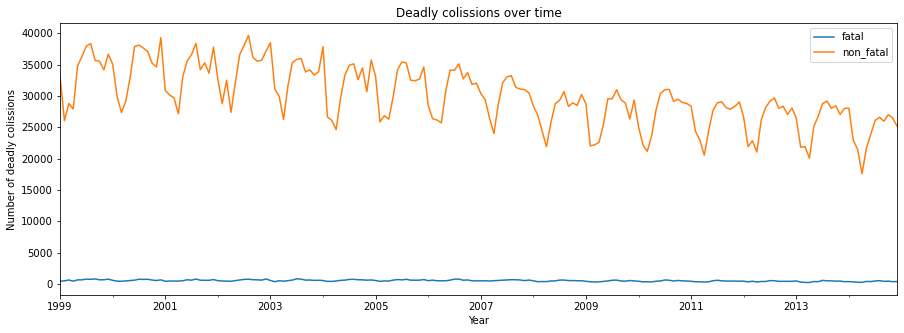

In [21]:
time_collision_both = df_ts.groupby('date')["fatal","non_fatal"].sum()
plot = time_collision_both.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

A grandes rasgos y en una primera impresión, podemos realizar dos afirmaciones:

- Parece existir un componente estacional para la variable objetivo, con ciclos anuales.

- Existe una gran diferencia de magnitudes entre los distintos valores de la variable objetiva (mucho mayor número de casos $non fatal$ que $fatal$)


Repetimos solo con los accidentes fatales:

Text(0, 0.5, 'Number of deadly colissions')

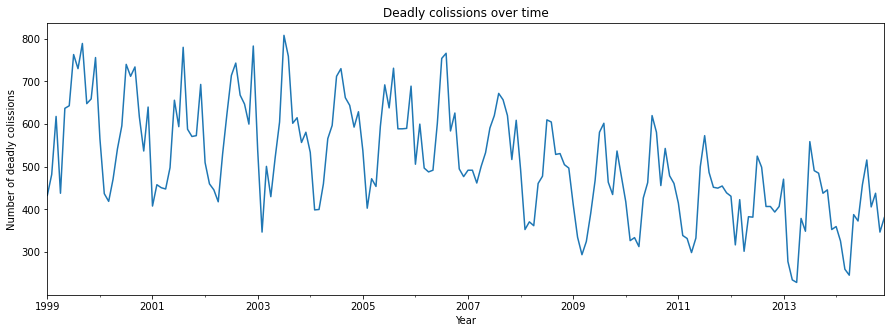

In [22]:
time_collision_fatal = df_ts.groupby('date')["fatal"].sum()
plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Podemos confirmar que efectivamente existe un componente estacional que afecta a las colisiones mortales.

Text(0, 0.5, 'Number of non-deadly colissions')

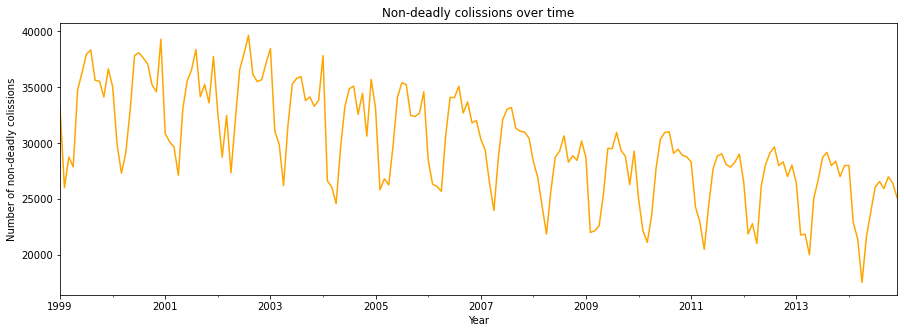

In [23]:
time_collision_nonfatal = df_ts.groupby('date')["non_fatal"].sum()
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Non-deadly colissions over time", color = "orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of non-deadly colissions")

Ocurre lo mismo con las colisiones no mortales.

### 1.2. Observación reducida a los últimos 5 años

Con el objetivo de observar de manera más clara y concisa la estacionalidad, reducimos el periodo de observación. La primera observación empieza en 2009.

Text(0, 0.5, 'Number of deadly colissions')

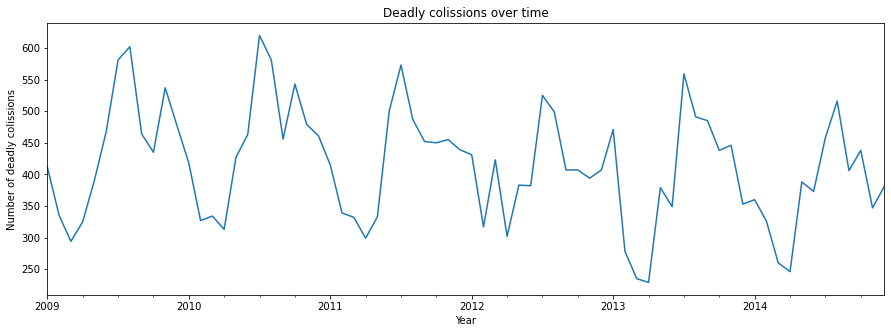

In [24]:
df_reduced = df_ts.loc[df_ts["date"] >= "2009"]
time_collision_fatal = df_reduced.groupby('date')["fatal"].sum()


plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Text(0, 0.5, 'Number of deadly colissions')

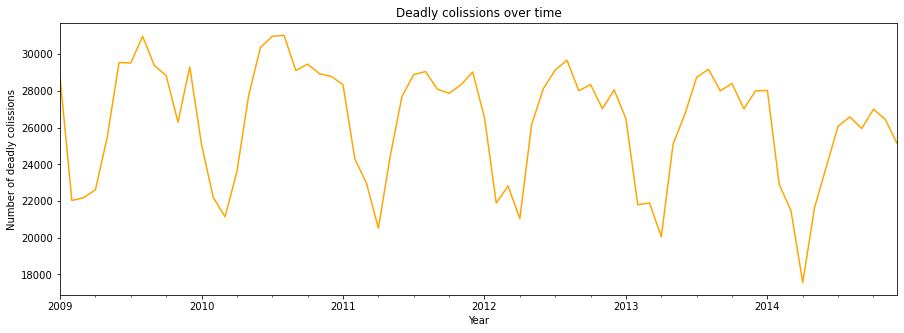

In [25]:
time_collision_nonfatal = df_reduced.groupby('date')["non_fatal"].sum()

plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color="orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

Confirmamos la estacionalidad para ambas series, pudiendo observar visualmente que los primeros meses del año tienen una tendencia negativa, mientras que la segunda mitad del año tiene una tendencia positiva y posterior estancamiento.

### 1.3 Correlación entre los valores de la variable objetivo

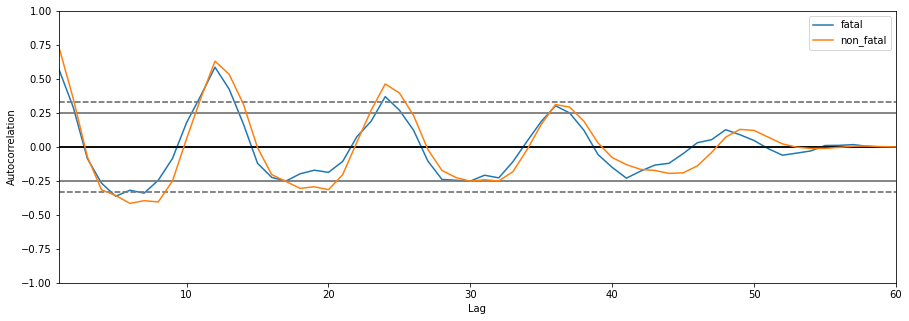

In [26]:
plt.figure(figsize=(15,5))
for c in time_collision_both.columns:
    autocorrelation_plot(time_collision_both[c][-60:],label=c);

La variable objetivo se comporta en gran medida de manera paralela para los dos valores que toma ($fatal$ y $non fatal$)

C:\Users\atell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



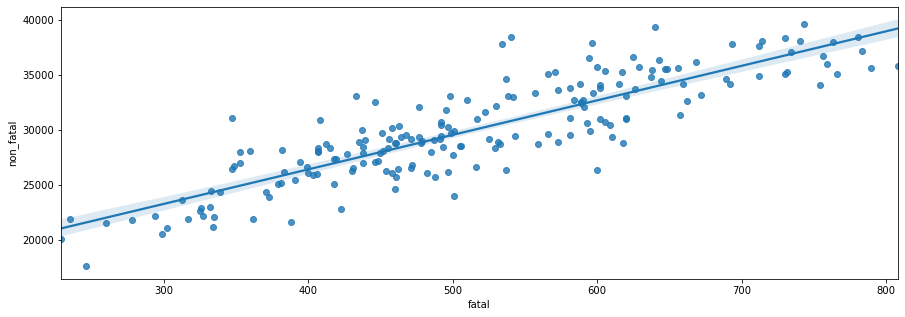

In [27]:
plt.figure(figsize=(15,5))
sns.regplot('fatal', 'non_fatal', data=time_collision_both);

La distribución de la variable objetivo entre sus valores 1 y 0 sigue una regresión lineal simple.

In [28]:
corr = time_collision_both.corr()
print("La correlación entre los accidentes fatales y no fatales es de", str(round(corr["fatal"]["non_fatal"], 3)))
corr

La correlación entre los accidentes fatales y no fatales es de 0.865


,fatal,non_fatal
fatal,1.000000,0.864582
non_fatal,0.864582,1.000000


## 2. Análisis temporal

Además de realizar un análisis de la variable tiempo en su conjunto como hemos hecho previamente en este documento para obtener una noción general de cómo afecta este a la variable objetivo, vamos a analizar las variables temporales $month, weekday$ y $hour$ de manera individual 

### 2.1. Meses del año

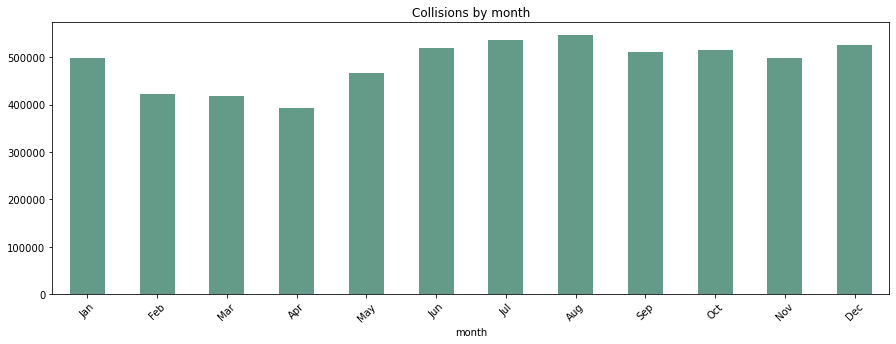

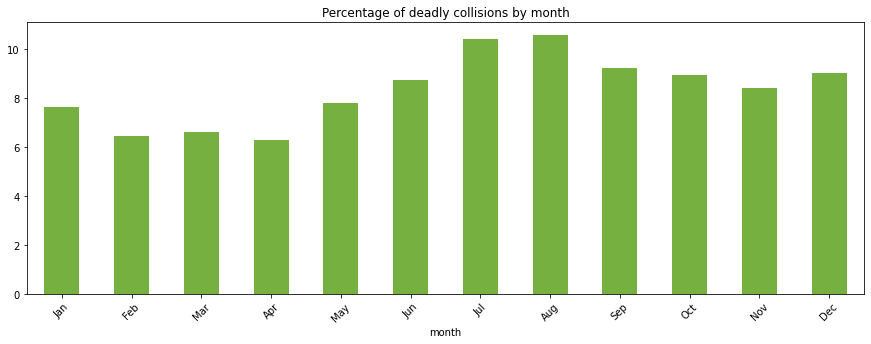

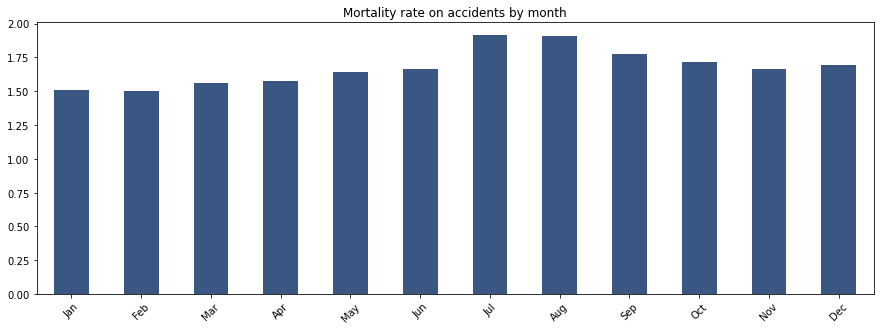

In [31]:
#FIXME: Bug inexplicable en este plot
tipos = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
frecuencia("month", tipos, "Collisions by month")
mortalidadtotal("month", tipos, "Percentage of deadly collisions by month")
mortalidad("month", tipos, "Mortality rate on accidents by month")

### Conclusión:
Observamos cómo un mayor porcentaje de los accidentes ocurre en los meses correspondientes al tercer trimestre del año, y existe un componente cíclico en la mortalidad de los accidentes.

En consecuencia, la medida que tomaremos será hacer que la variable o columna $month$ tome un valor entre 1 y 4 en función del trimestre del año al que pertenezca (Q1, Q2...)

### 2.2. Días de la semana

In [32]:
df["weekday"] = np.int8(df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
df = df[df["weekday"] != 0]
df['weekday'].unique()

<ipython-input-32-9b04056ad093>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([1, 2, 3, 4, 5, 6, 7], dtype=int8)

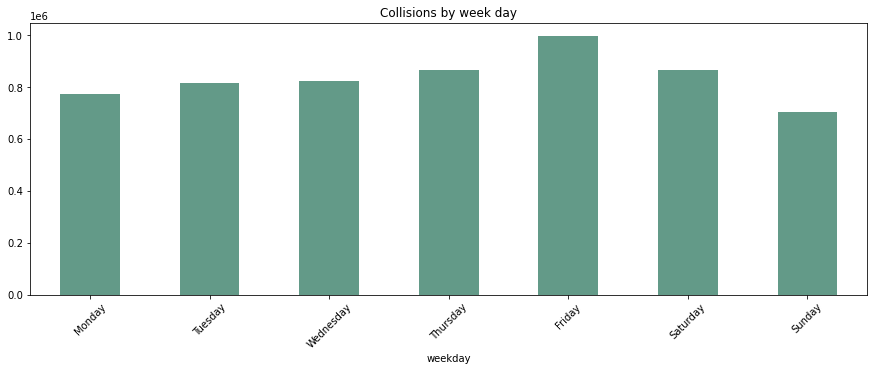

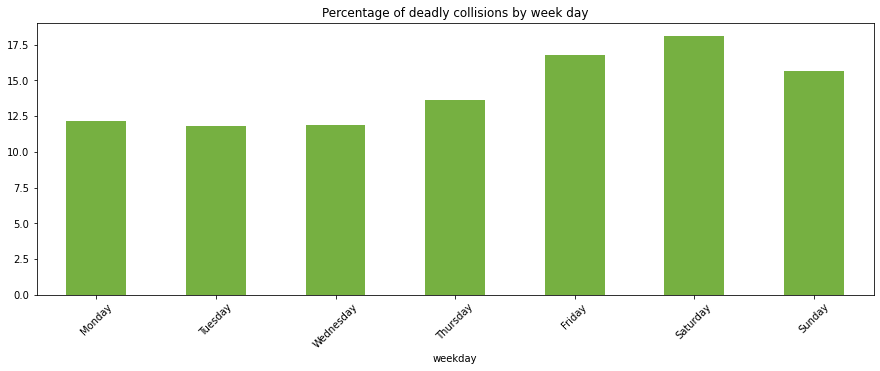

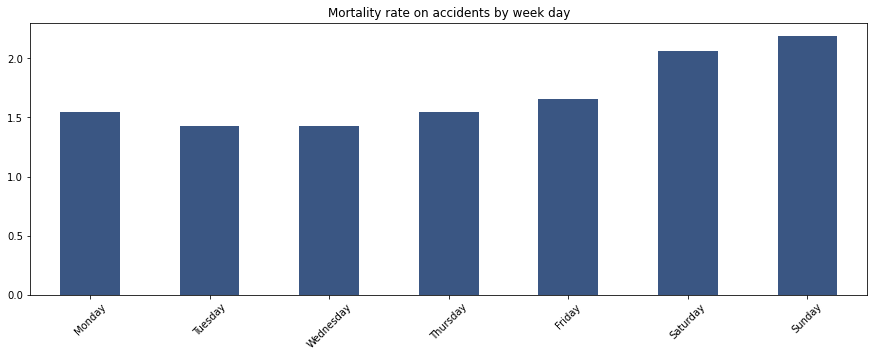

In [36]:
tipos = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
frecuencia("weekday", tipos, "Collisions by week day")
mortalidadtotal("weekday", tipos, "Percentage of deadly collisions by week day")
mortalidad("weekday", tipos, "Mortality rate on accidents by week day")

### Conclusión:

De manera similar a lo que observamos en la variable month, existe una clara relación entre la variable $weekday$ y la variable objetivo. En este caso, podemos observar como la mortalidad por accidente aumenta según se acerca el fin de semana y decrece una vez pasado este.

La medida que tomaremos para tener en cuenta correctamente la variable month a la hora de modelizar será dividirla en tres valores:

- Si nos encontramos en Sábado o Domingo, la variable tomará un valor.

- Si nos encontramos en Lunes, Jueves o Viernes, la variable tomará otro valor.

- Por último, la variable tomará otro valor si estamos hablando de un Martes o Miércoles.

### 2.3. Horas del día

<ipython-input-37-25169a1f03ed>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



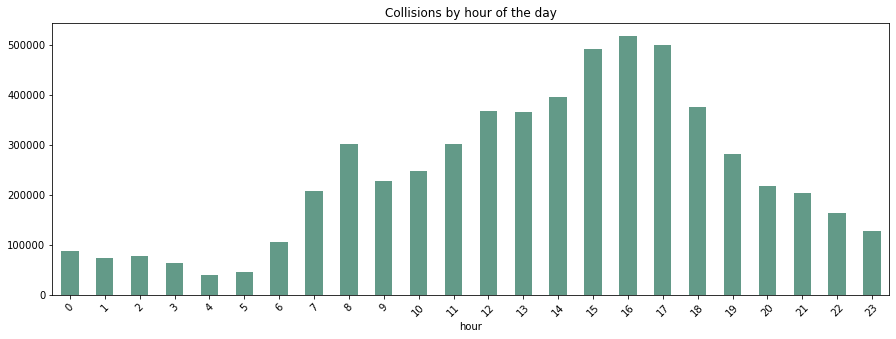

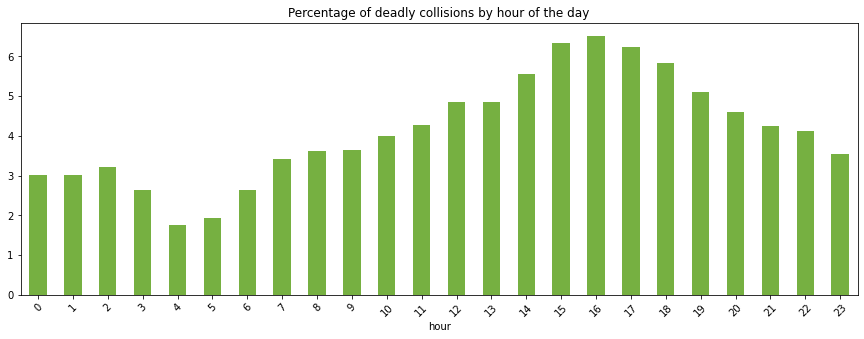

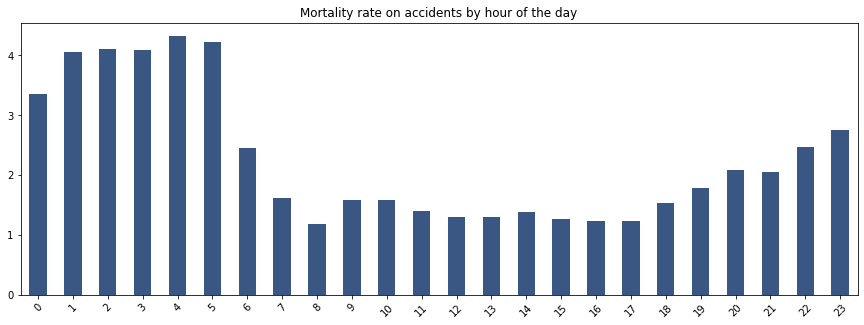

In [37]:
df = df[df["hour"].notnull()]
df["hour"] = df["hour"].astype("int8")

tipos = list(range(0, 24))
frecuencia("hour", tipos, "Collisions by hour of the day")
mortalidadtotal("hour", tipos, "Percentage of deadly collisions by hour of the day")
mortalidad("hour", tipos, "Mortality rate on accidents by hour of the day")

### Conclusión:

Observamos como la mayoría de accidentes se agrupan en el intervalo horario comprendido entre las 13 y las 19h. Podemos asumir, a grandes rasgos, que se debe a los horarios de salida del trabajo.

Sin embargo, y a pesar de esto, la probabilidad de que se de mortalidad en un accidente es relativamente baja y estable en el caso de las horas con luz. La mayor mortalidad se encuentra condensada en la madrugada. Podemos asumir que se debe a un mayor grado de conducción bajo los efectos de las drogas y/o el alcohol, así como una menor visibilidad y mayor cansancio.

Para conseguir que nuestros modelos sepan reflejar correctamente la importancia de la hora en la que ocurre el accidente, dividiremos esta variable en distintos valores:

- 0 a 5
- 6 a 8
- 9 a 18
- 19 a 21
- 22 a 23

## 3. Colisiones y Carretera

### 3.1. Road Configuration

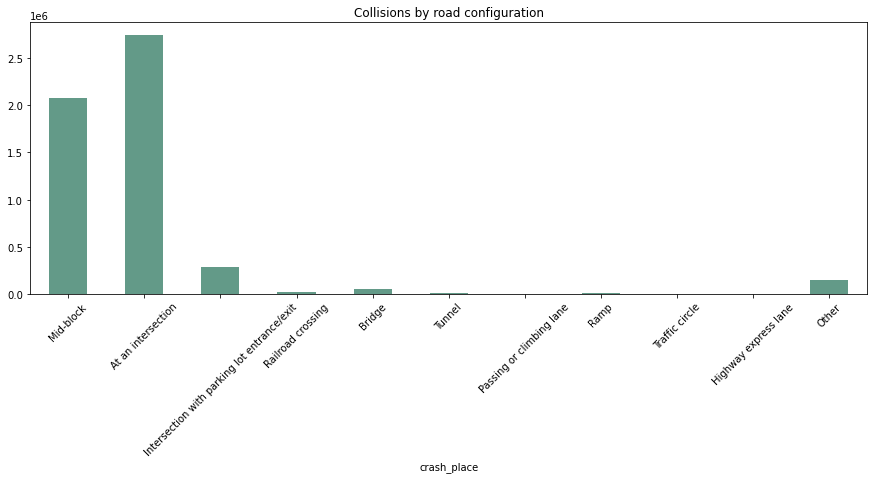

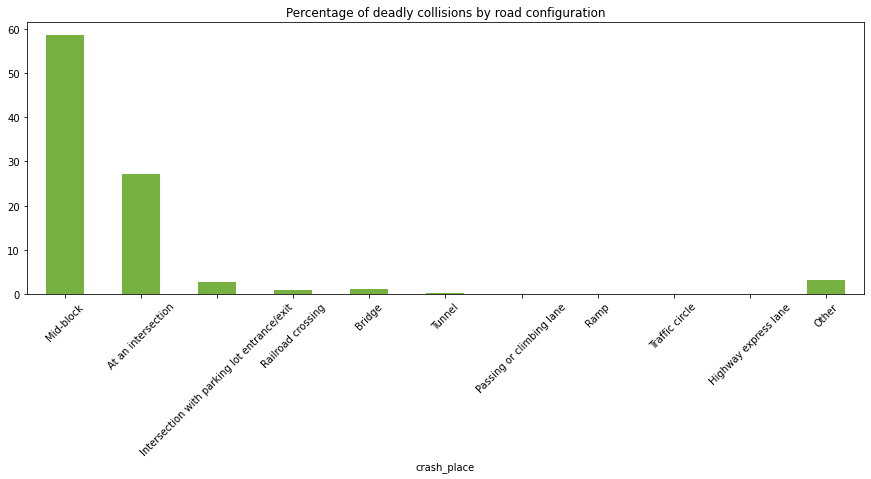

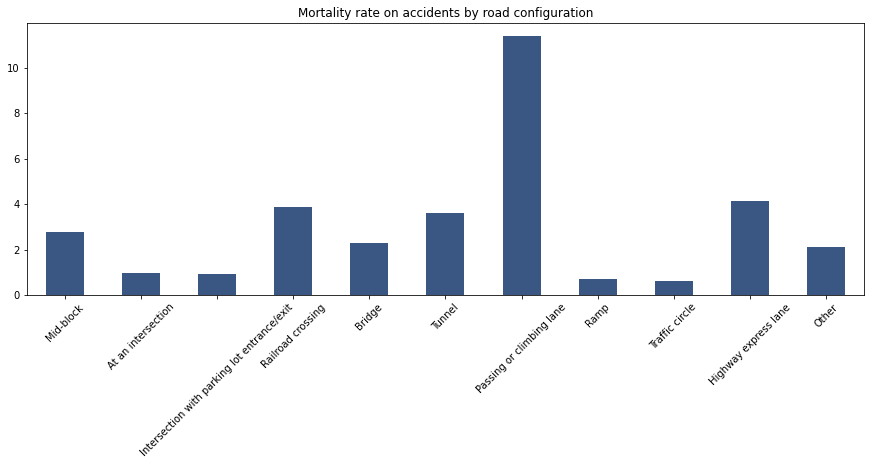

In [38]:
tipos = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane', 'Other']

frecuencia("crash_place", tipos, "Collisions by road configuration")
mortalidadtotal("crash_place", tipos, "Percentage of deadly collisions by road configuration")
mortalidad("crash_place", tipos, "Mortality rate on accidents by road configuration")

### Conclusión:

Observamos que a pesar de que la mayoría de los accidentes ocurren en el sentido de la marcha ($mid-block$) y en intersecciones, tienen una mortalidad relativamente baja.

Cabe destacar la alta mortalidad de los accidentes en los carriles de adelantamiento y carriles VAO ($highway express lane$), que probablemente estén causados por una muestra reducida pero que aún así hemos de tener muy en cuenta.

Las medidas a la hora de modificar la variable que tomaremos dividirán la variable de la siguiente manera:

- Passing or climbing lane tomará un valor.

- Mid-block, Railroad crossing, Highway express lane, Bridge, Tunnel y Other tomarán otro valor.

- El resto de valores tomarán un valor genérico.

### 3.2. Condiciones Climáticas

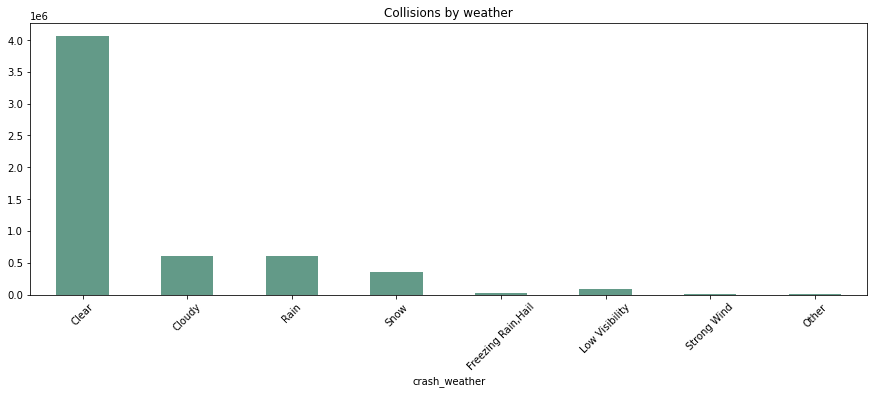

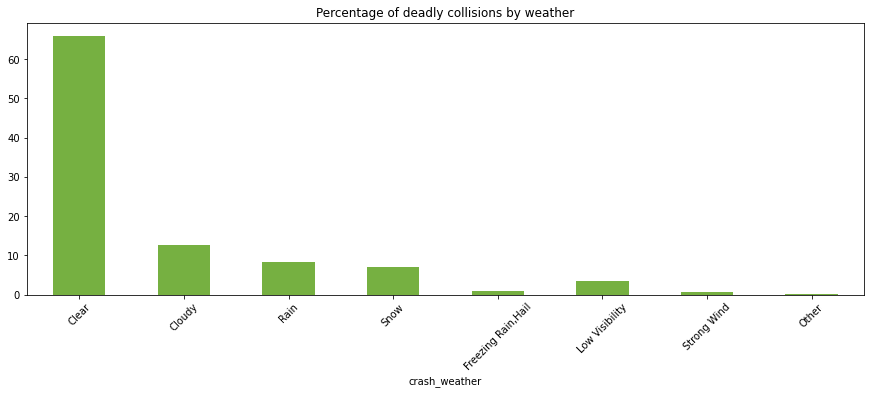

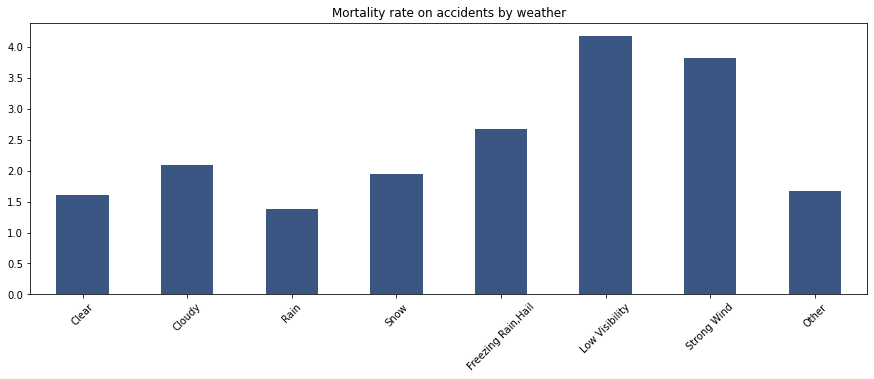

In [39]:
tipos = ['Clear','Cloudy','Rain','Snow','Freezing Rain,Hail',
                'Low Visibility','Strong Wind','Other']
frecuencia("crash_weather", tipos, "Collisions by weather")
mortalidadtotal("crash_weather", tipos, "Percentage of deadly collisions by weather")
mortalidad("crash_weather", tipos, "Mortality rate on accidents by weather")

### Conclusión:

La mayoría de los accidentes ocurren con situaciones meteorológicas casi idóneas ($clear$).

Por otro lado, la mortalidad de los accidentes es muy acentuada en aquellas situaciones de complicado manejo como las de baja visibilidad ($low visibility$) o adversas ($strong wind$ o $freezing rain, hail$)

Dividiremos la variable en los siguientes valores:

- Low Visibility y Strong Wind

- Clear, Rain y Other

- Cloudy y Snow

- Freezing Rain, Hail

### 3.3. Road surface

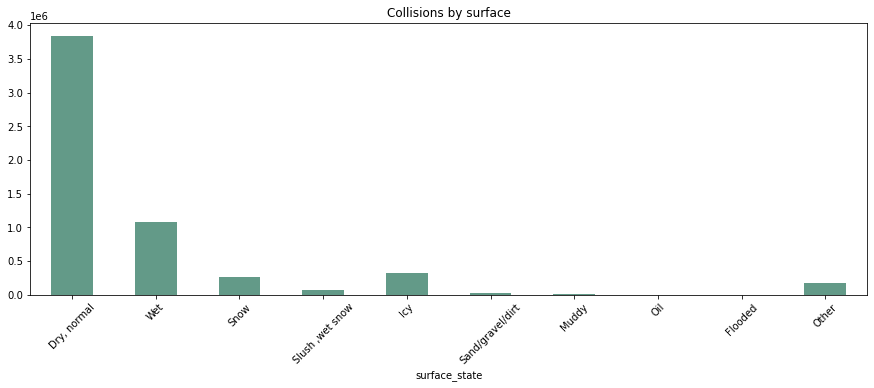

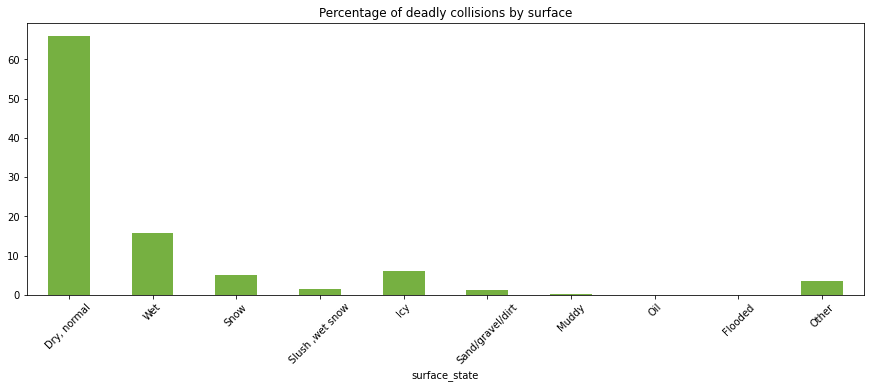

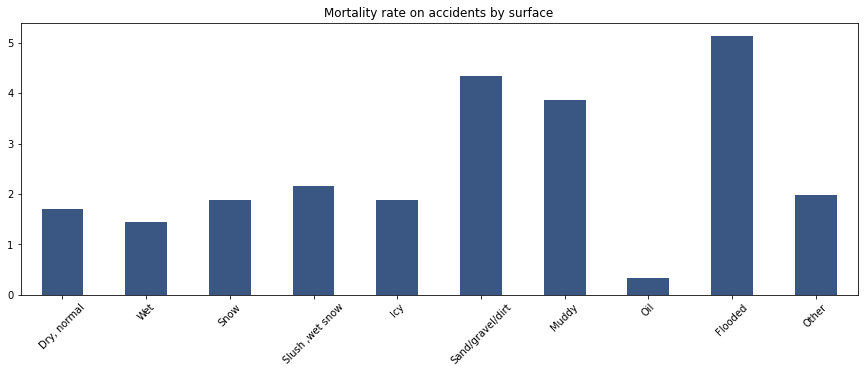

In [40]:
tipos = ['Dry, normal','Wet','Snow','Slush ,wet snow','Icy','Sand/gravel/dirt','Muddy','Oil','Flooded', 'Other']
frecuencia("surface_state", tipos, "Collisions by surface")
mortalidadtotal("surface_state", tipos, "Percentage of deadly collisions by surface")
mortalidad("surface_state", tipos, "Mortality rate on accidents by surface")

### Conclusión:

La mayoría de las observaciones se encuentra acumulada en el valor $Dry, normal$ (carretera seca y en un estado normal)

La mortalidad es mayor en aquellos casos en los que la superficie no se encontraba en un estado óptimo, o se encontraba en un estado que podemos considerar inesperado teniendo en cuenta que estamos hablando de Canadá (la nieve no lo es, aparentemente)

La variable será estructurada de la siguiente manera:

- Dry, Wet, Snow, Slush, Icy, Other

- Sand/gravel, Muddy, Flooded

- Oil

### 3.4. Traffic State

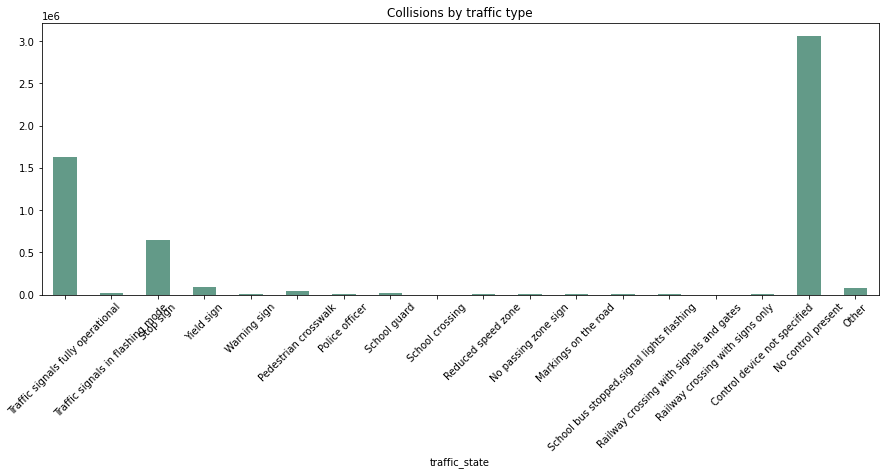

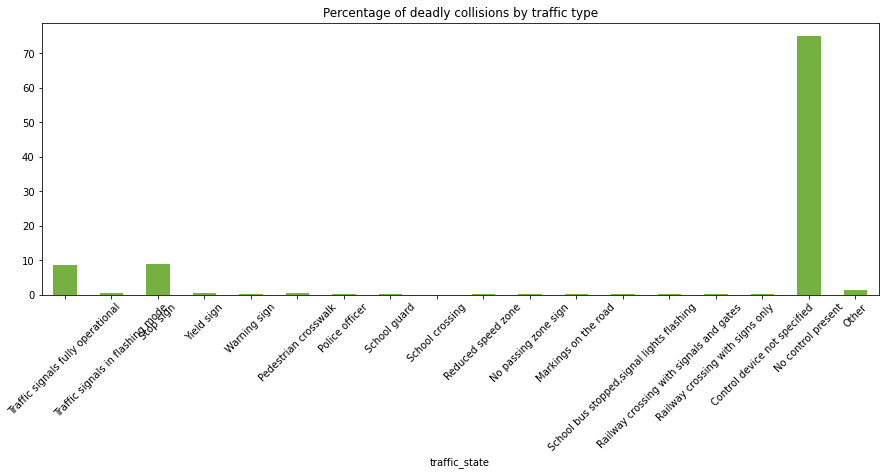

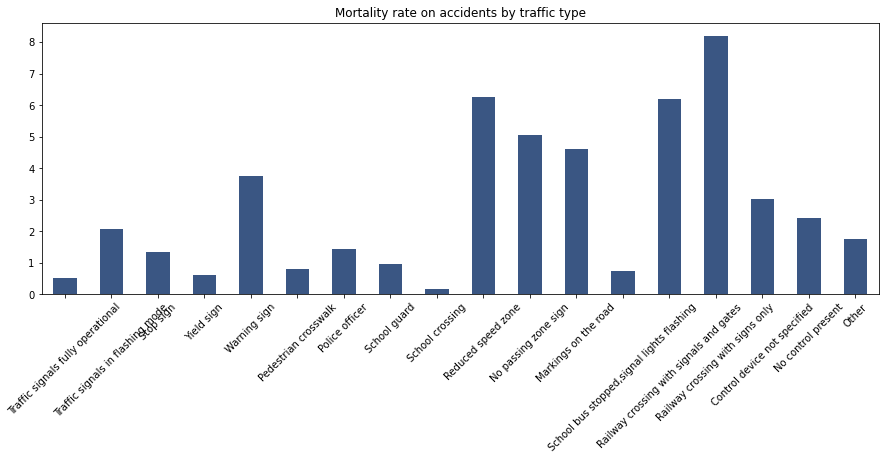

In [41]:
tipos = ['Traffic signals fully operational','Traffic signals in flashing mode',
             'Stop sign','Yield sign','Warning sign','Pedestrian crosswalk',
             'Police officer','School guard','School crossing','Reduced speed zone',
             'No passing zone sign','Markings on the road',
             'School bus stopped,signal lights flashing','Railway crossing with signals and gates',
             'Railway crossing with signs only','Control device not specified','No control present', 'Other']
             
frecuencia("traffic_state", tipos, "Collisions by traffic type")
mortalidadtotal("traffic_state", tipos, "Percentage of deadly collisions by traffic type")
mortalidad("traffic_state", tipos, "Mortality rate on accidents by traffic type")

### Conclusión:

En la mayoría de los accidentes, no existe una restricción sobre la circulación.

En cuanto a la mortalidad, existe una gran variabilidad en cuanto a los distintos valores de la variable $traffic-state$. Acorde con esto, estructuraremos la variable como una variable categórica a la hora de llevarla a los modelos.

### 3.5. Road alignment (slope)

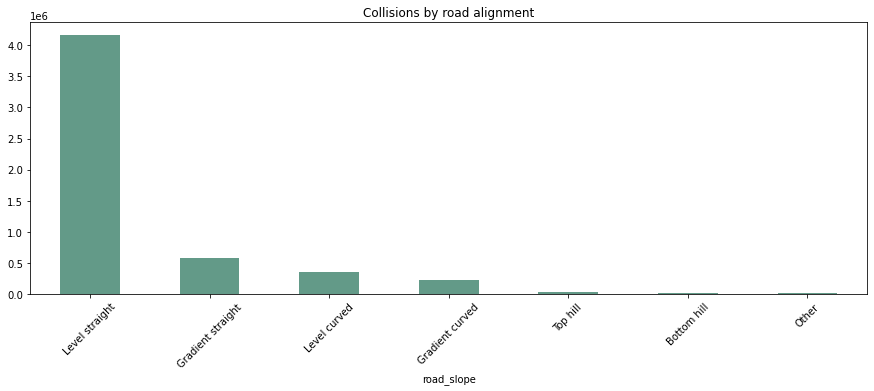

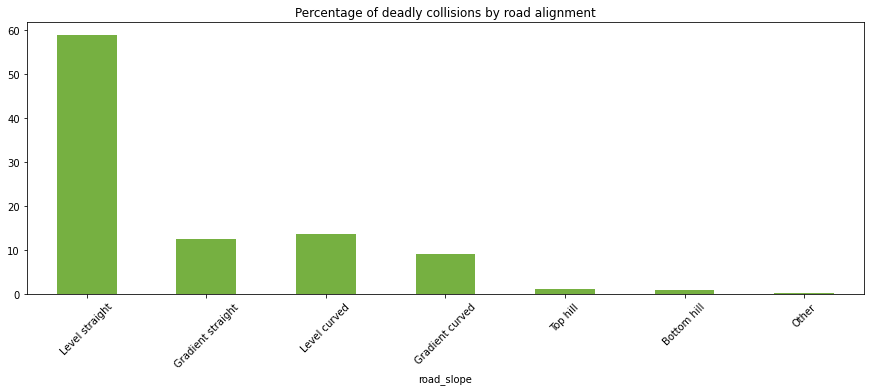

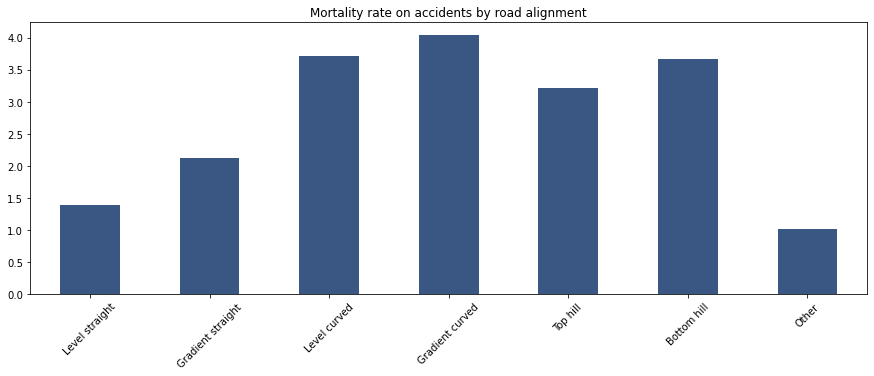

In [42]:
tipos = ['Level straight','Gradient straight',
        'Level curved','Gradient curved',
        'Top hill','Bottom hill',
        'Other']
             
frecuencia("road_slope", tipos, "Collisions by road alignment")
mortalidadtotal("road_slope", tipos, "Percentage of deadly collisions by road alignment")
mortalidad("road_slope", tipos, "Mortality rate on accidents by road alignment")

### Conclusión:

La mayoría de los accidentes ocurren en rectas sin inclinación.

En este caso, no trataremos la variable por no ser capaces realmente de establecer diferencias notables entre sus valores.

 ### 3.6. Vehicles Involved

Text(0.5, 1.0, 'Mortality rate by vehicles involved in collision')

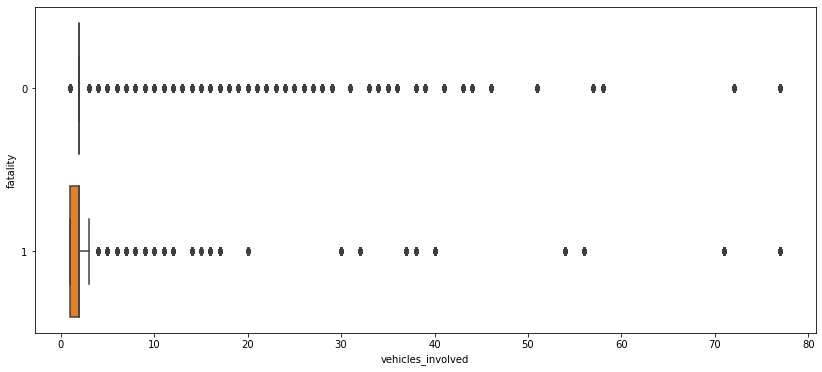

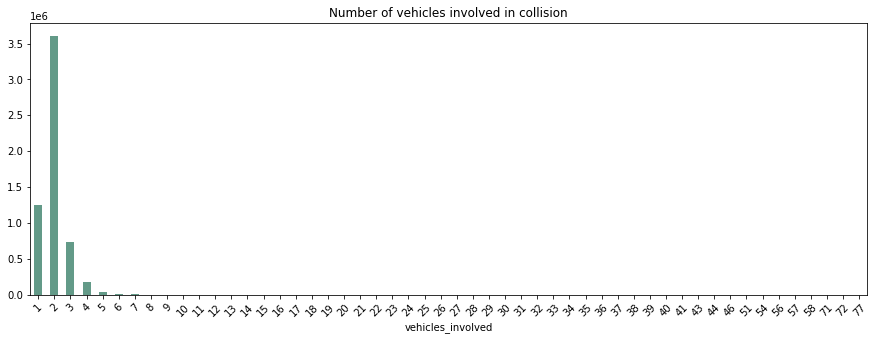

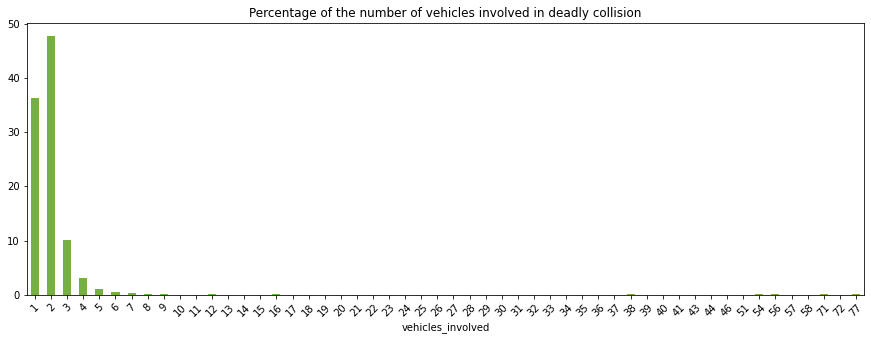

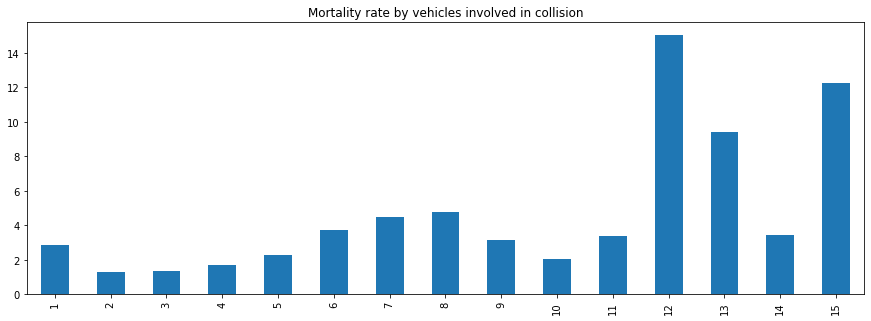

In [43]:
tipos = sorted(np.int16(df['vehicles_involved'].dropna().unique()))
boxplot_fatality("vehicles_involved")
frecuencia("vehicles_involved", tipos, "Number of vehicles involved in collision")
mortalidadtotal("vehicles_involved", tipos, "Percentage of the number of vehicles involved in deadly collision")

analysis = df.loc[(df['vehicles_involved'] < 17)].groupby(['vehicles_involved', "fatality"]).size()
serie = list()
for i in range(0, np.int8(len(analysis)/2)):
    serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)  
plt.figure(figsize=(15,5))
pd.Series(serie).plot(kind="bar").set_xticklabels(list(range(1,16)))
plt.title("Mortality rate by vehicles involved in collision")

## 4. Vehicles

### 4.1. Vehicle type

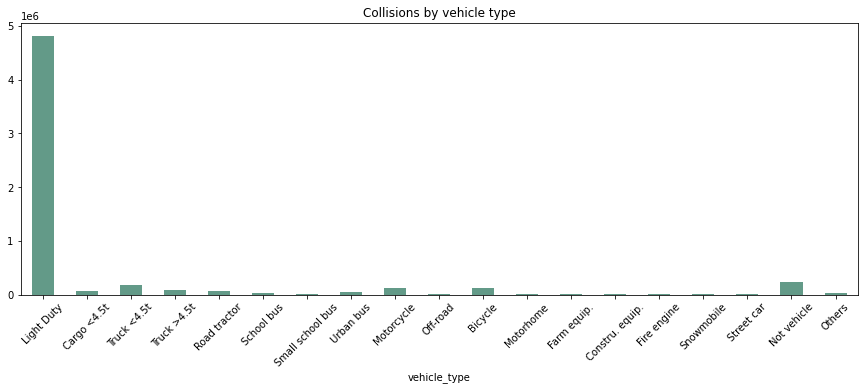

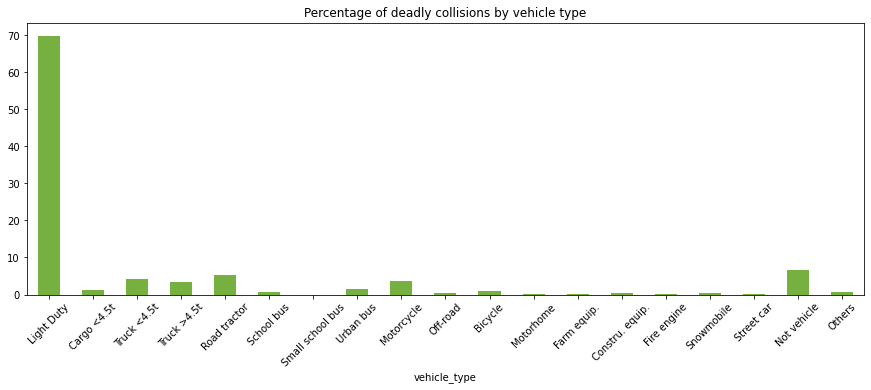

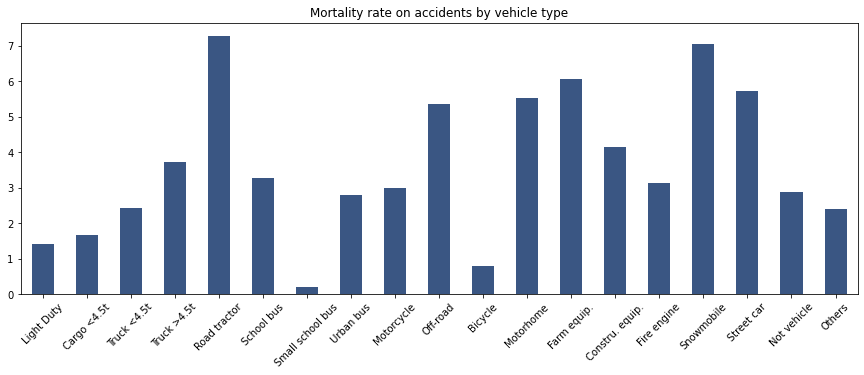

In [44]:
tipos = v_type = ['Light Duty', 'Cargo <4.5t', 'Truck <4.5t',
          'Truck >4.5t', 'Road tractor', 'School bus',
          'Small school bus', 'Urban bus', 'Motorcycle',
          'Off-road', 'Bicycle', 'Motorhome', 'Farm equip.',
          'Constru. equip.', 'Fire engine', 'Snowmobile',
          'Street car', 'Not vehicle', 'Others']
             
frecuencia("vehicle_type", tipos, "Collisions by vehicle type")
mortalidadtotal("vehicle_type", tipos, "Percentage of deadly collisions by vehicle type")
mortalidad("vehicle_type", tipos, "Mortality rate on accidents by vehicle type")

### Conclusión:

La mayoría de los accidentes se han dado con conductores de coches light-weight (o turismos), lo cual era de esperar teniendo en cuenta que componen la inmensa mayoría de los vehículos que circulan por la carretera
Debido a baja diferenciación entre las categorías de la variable, no modificaremos esta variable tramificándola como sí hemos hecho con otras variables previamente.

### 4.2. Vehicle Age

Con la creación de la variable $vehicle-age$ hemos sustituido la variable $vehicle-year$, ya que consideramos que la antigüedad del vehículo resulta determinante a la hora de estimar el riesgo mortal en un accidente.

Hemos hecho esto por que la variable $vehicle-year$ y su consecuente tendencia a reducir el riesgo mortal cuanto más moderno es el vehículo ya será reflejada en nuestro modelo mediante la variable year, como pudimos observar en el análisis inicial de la variable objetivo.

Text(0.5, 1.0, 'Mortality rate by vehicle age')

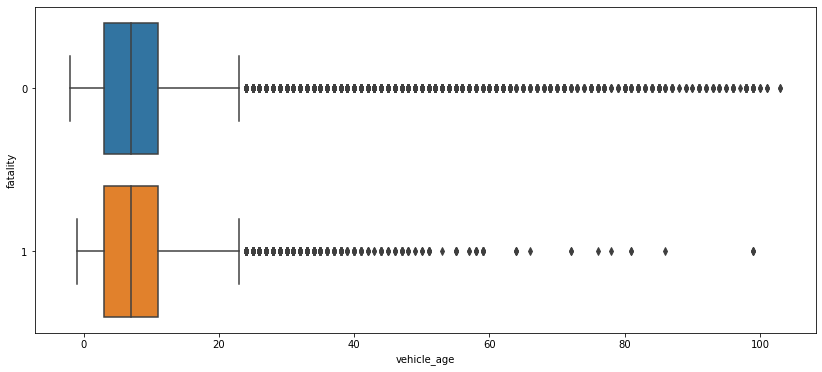

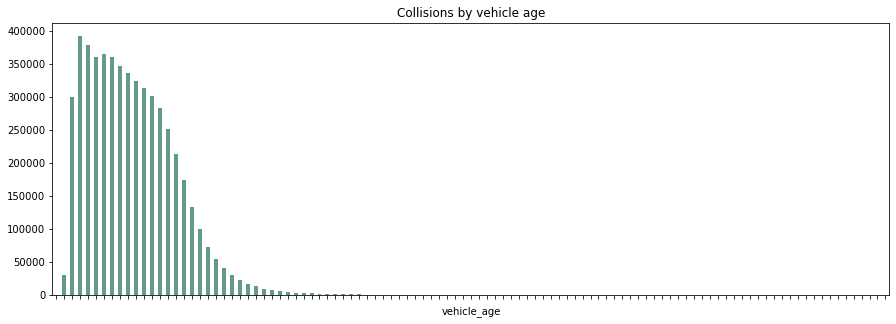

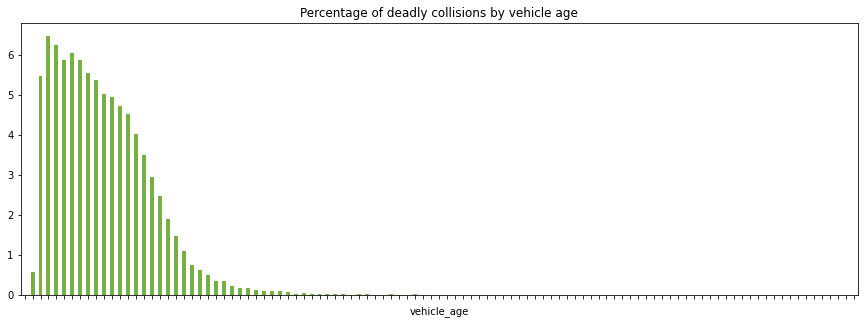

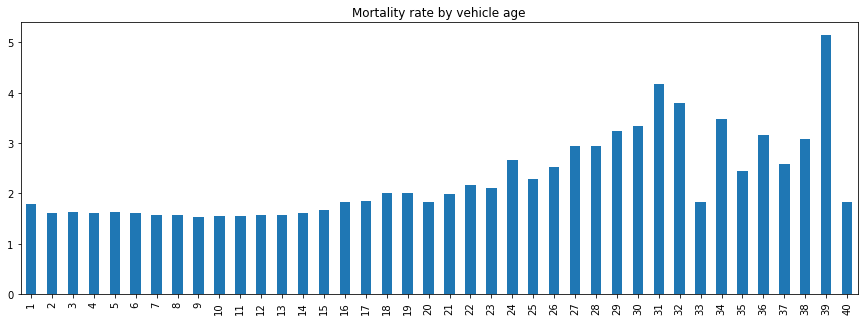

In [45]:
tipos = ()
boxplot_fatality('vehicle_age')
frecuencia("vehicle_age", tipos, "Collisions by vehicle age")
mortalidadtotal("vehicle_age", tipos, "Percentage of deadly collisions by vehicle age")


analysis = df.loc[(df['vehicle_age'] < 40) & (df['vehicle_age'] >= 0)].groupby(['vehicle_age', "fatality"]).size()
serie = list()
for i in range(0, np.int8(len(analysis)/2)):
    serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)  
plt.figure(figsize=(15,5))
pd.Series(serie).plot(kind="bar").set_xticklabels(list(range(1,41)))
plt.title("Mortality rate by vehicle age")

### Conclusión:

Podemos observar cómo la mortalidad por accidente se acentúa según aumenta la antigüedad del vehículo, como era de esperar. También vemos como la distiubción de la variable presenta una asimetría a la derecha y que está marcada por la presencia de outliers tal como muestra el boxplot. Esto tiene una explicación muy sencilla, la inmensa mayoria de vehiculos en circulación no supera los 25 años. Sin embargo, existen vehículos de colección y antiguedades que circulan muy poco y que también pueden verse involucrados en un accidente.

## Driver type

### 5.1. Driver Sex

Realizamos cierto tratamiento de los datos para la variable sexo que posteriormente será útil.

In [46]:
# Replace M/F to 1/0
df.passenger_sex.replace({"M":1, "F":0}, inplace=True)

# Remove NA values (15k rows, 0.3% of total sample)
df.passenger_sex.replace('[^0-9]+',np.nan,regex=True,inplace=True)
df.passenger_sex.dropna(inplace=True)


C:\Users\atell\anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-212d636216c0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



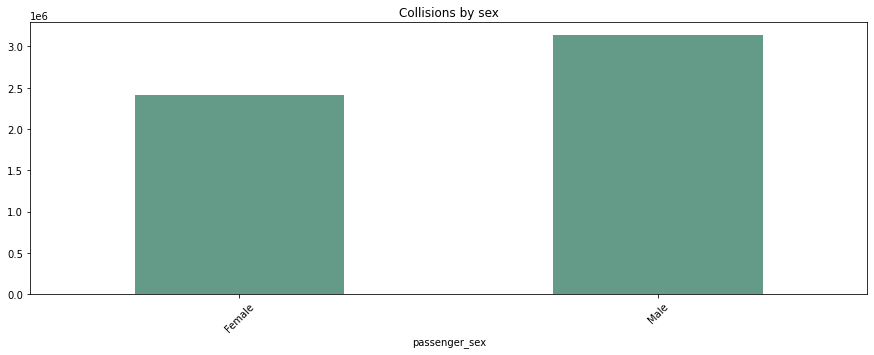

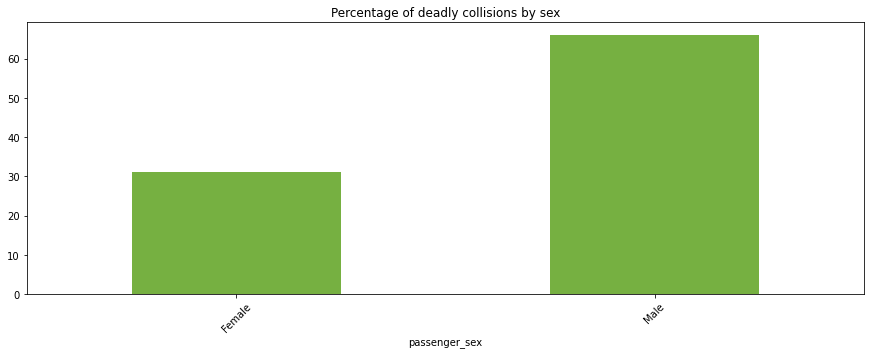

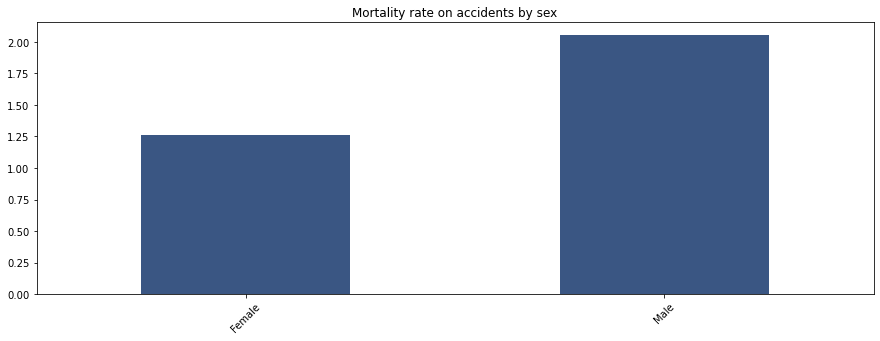

In [50]:
tipos = ["Female", "Male"]
frecuencia("passenger_sex", tipos, "Collisions by sex")
mortalidadtotal("passenger_sex", tipos, "Percentage of deadly collisions by sex")
mortalidad("passenger_sex", tipos, "Mortality rate on accidents by sex")

### Conclusión:

Los hombres sufren de una mayor mortalidad en los accidentes así como una mayor cantidad de accidentes en total.

### 5.2. Driver Age

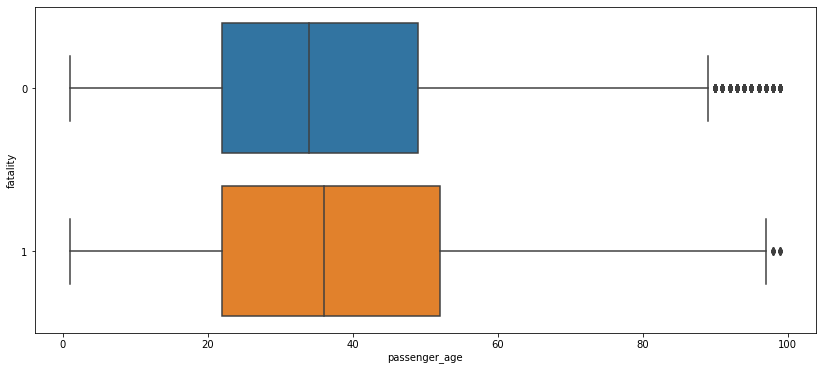

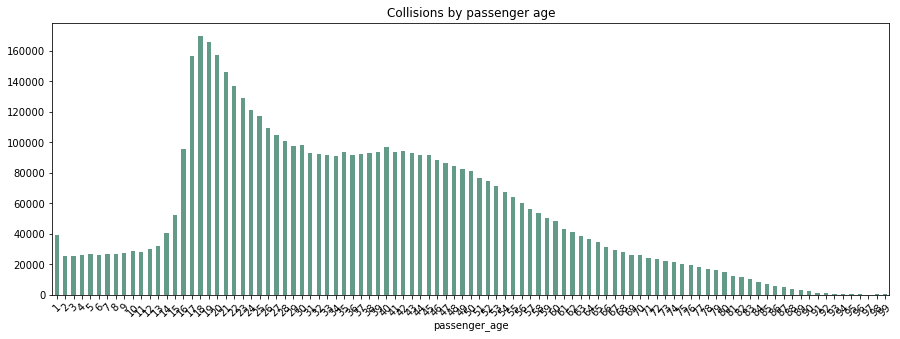

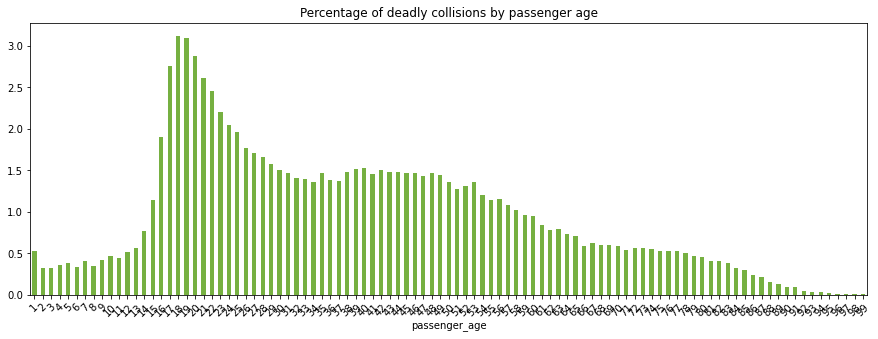

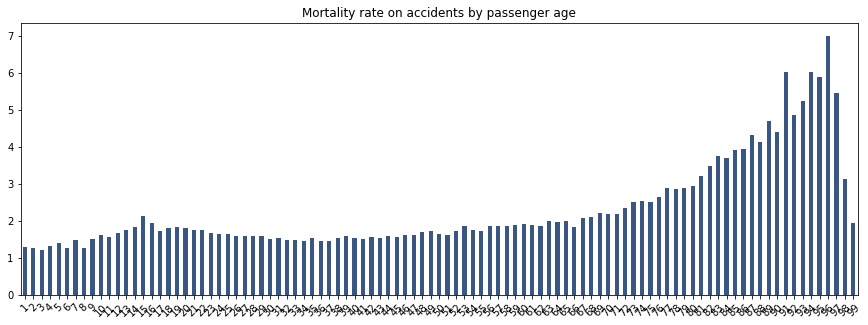

In [51]:
tipos = sorted(np.int8(df['passenger_age'].dropna().unique()))
boxplot_fatality("passenger_age")
frecuencia("passenger_age", tipos, "Collisions by passenger age")
mortalidadtotal("passenger_age", tipos, "Percentage of deadly collisions by passenger age")
mortalidad("passenger_age", tipos, "Mortality rate on accidents by passenger age")

### 5.3. Driver safety

In [52]:
df = df.loc[df['passenger_safety'] != "11"]

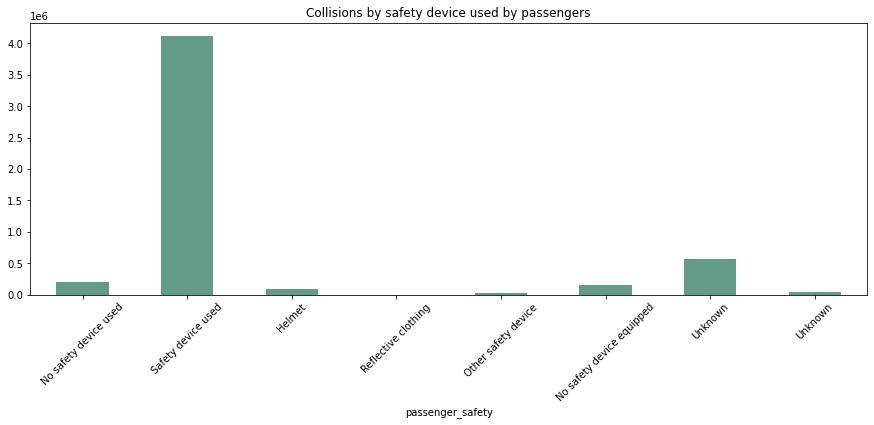

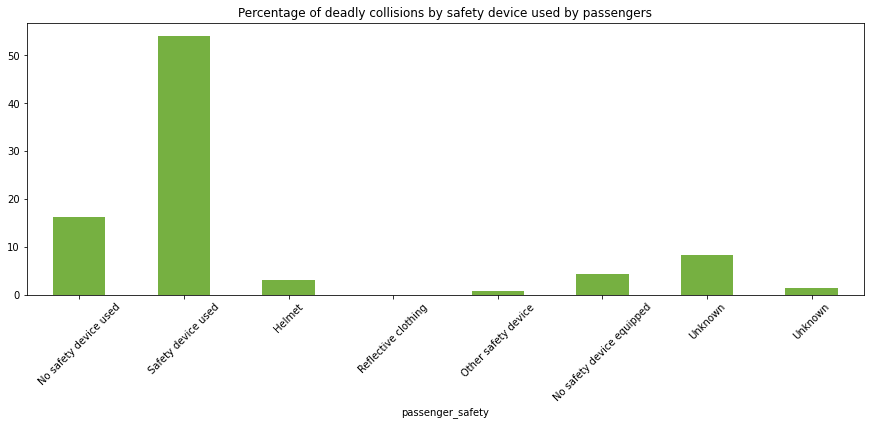

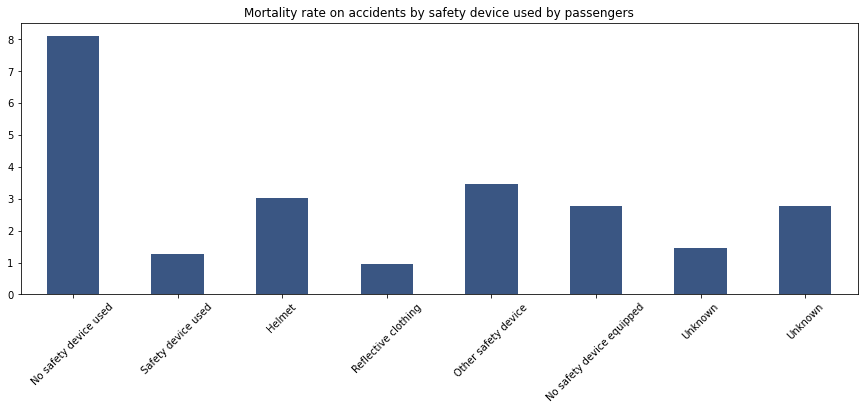

In [55]:
tipos = ['No safety device used','Safety device used','Helmet',
          'Reflective clothing',
          'Other safety device','No safety device equipped', 'Unknown', 'Unknown']


frecuencia("passenger_safety", tipos, "Collisions by safety device used by passengers")
mortalidadtotal("passenger_safety", tipos, "Percentage of deadly collisions by safety device used by passengers")
mortalidad("passenger_safety", tipos, "Mortality rate on accidents by safety device used by passengers")

### Conclusión:

El uso de dispositivos de seguridad como puede ser el cinturón de seguridad en el caso de los coches o el casco en el caso de las motocicletas resulta determinante para reducir la mortalidad en caso de accidente.
Cabe mencionar la alta mortalidad de los usuarios que utilizan casco, posiblemente causada por el alto riesgo que supone estar involucrado en un accidente con una moto.

Dividiremos la variable en las siguientes franjas:

- No safety device used

- Helmet, Other safety device, no safety device equipped, Unknown (2)

- Safety device used, Reflective clothing, Unknown (1)

### 5.4. Road User Type

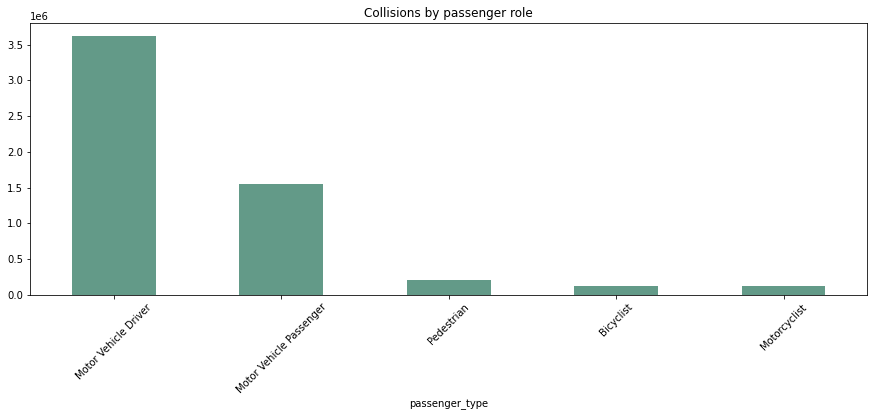

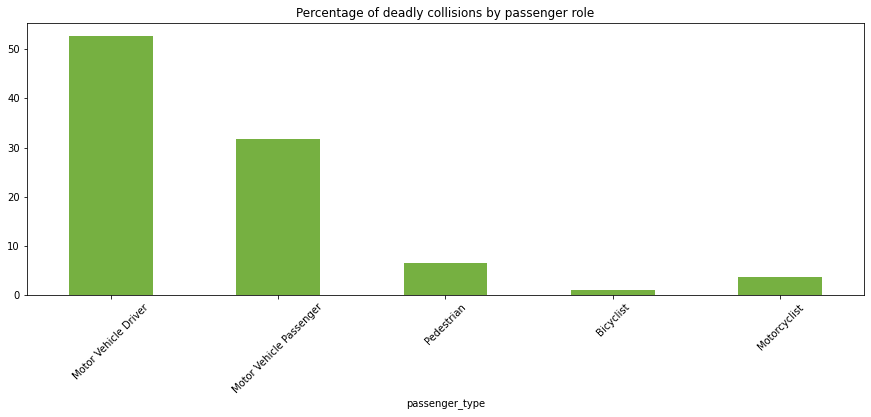

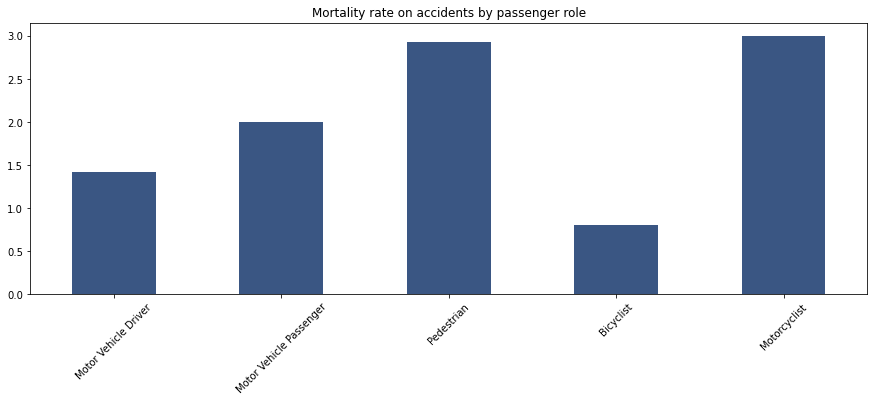

In [56]:
tipos = ["Motor Vehicle Driver", "Motor Vehicle Passenger", "Pedestrian", "Bicyclist", "Motorcyclist"]
frecuencia("passenger_type", tipos, "Collisions by passenger role")
mortalidadtotal("passenger_type", tipos, "Percentage of deadly collisions by passenger role")
mortalidad("passenger_type", tipos, "Mortality rate on accidents by passenger role")

# Relación entre variables: V de Cramer y Correlación

In [57]:
def cramers_corrected_stat(x,y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [58]:
#Añado fatality a la lista de categoricas para ver como se relacionan con la V de Cramer
if 'fatality' not in categoricas_pre: 
    categoricas_pre.append('fatality')
categoricas_pre.remove("vehicle_id")

In [59]:
# SLOW!!! + 5mins
# Matriz con valores de la V de Cramer
rows= []
for var1 in categoricas_pre:
  col = []
  for var2 in categoricas_pre :

    cramers =cramers_corrected_stat(df[var1], df[var2]) # Test V de Cramer
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
cramer_matrix = pd.DataFrame(cramers_results, columns = categoricas_pre, index = categoricas_pre)
cramer_matrix


,month,weekday,hour,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_type,passenger_sex,passenger_role,passenger_safety,passenger_type,fatality
month,1.00,0.01,0.03,0.03,0.01,0.13,0.18,0.01,0.01,0.05,0.02,0.02,0.04,0.08,0.01
weekday,0.01,1.00,0.09,0.03,0.02,0.01,0.01,0.02,0.02,0.03,0.01,0.04,0.02,0.06,0.02
hour,0.03,0.09,1.00,0.06,0.03,0.04,0.04,0.04,0.02,0.03,0.09,0.03,0.04,0.05,0.06
crash_type,0.03,0.03,0.06,1.00,0.18,0.10,0.09,0.14,0.13,0.11,0.05,0.12,0.16,0.22,0.16
crash_place,0.01,0.02,0.03,0.18,1.00,0.06,0.05,0.10,0.24,0.05,0.04,0.03,0.04,0.05,0.07
crash_weather,0.13,0.01,0.04,0.10,0.06,1.00,0.36,0.05,0.05,0.04,0.01,0.02,0.03,0.04,0.03
surface_state,0.18,0.01,0.04,0.09,0.05,0.36,1.00,0.06,0.06,0.05,0.02,0.03,0.05,0.06,0.02
road_slope,0.01,0.02,0.04,0.14,0.10,0.05,0.06,1.00,0.10,0.05,0.02,0.03,0.04,0.04,0.06
traffic_state,0.01,0.02,0.02,0.13,0.24,0.05,0.06,0.10,1.00,0.04,0.04,0.05,0.04,0.05,0.07
vehicle_type,0.05,0.03,0.03,0.11,0.05,0.04,0.05,0.05,0.04,1.00,0.18,0.28,0.35,0.87,0.07


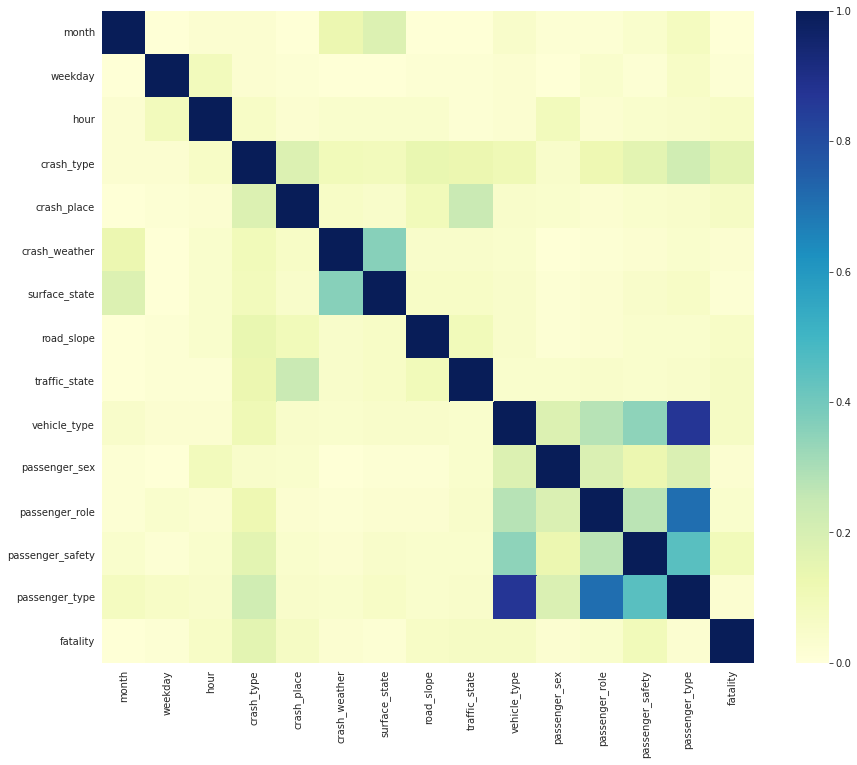

In [60]:
# Heatmap v de cramer entre variables
plt.figure(figsize=(15,12))
with sns.axes_style("white"):
  ax = sns.heatmap(cramer_matrix,vmin=0., vmax=1, square=True, cmap="YlGnBu")
plt.show()

<AxesSubplot:>

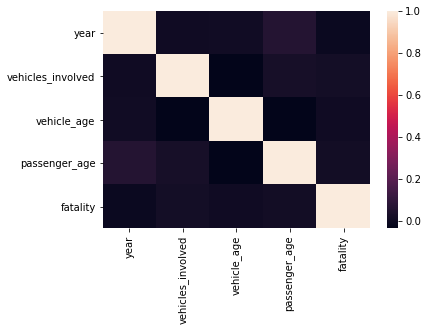

In [61]:
sns.heatmap(df[numericas_pre].corr())

 # Agregación DataFrame

Uno de los problemas fundamentales de nuestro conjunto de datos es que mezcla varios niveles de los datos en la misma tabla. En concreto, mezcla tres niveles, el de accidente, el de vehículo y el de persona, siendo cada fila de los datos una persona. Si por ejemplo tenemos un accidente con tres vehículos y dos personas por vehículo tendremos seis filas de nuestro dataset idénticas en cuanto a las características del accidente y tres pares de filas idénticas en cuanto a características de vehículo y accidente. Esto es problemático porque nuestra variable objetivo es una variable a nivel de accidente que nos indica si ese accidente resultó en al menos una muerte. Por tanto, en el ejemplo anterior si en la colisión hubiera fallecido una persona tendríamos seis filas que indicarían fallecimiento en la variable objetivo. Esto para el análisis descriptivo que hemos realizado no tiene demasiada importancia. Sin embargo, a la hora de estimar un modelo debemos transformar el dataset agregando por vehículo o por accidente para no introducir sesgo. Como inconveniente perderemos información a nivel de pasajeros y vehículo. Por ello debemos buscar un equilibrio que minimice el sesgo y maximice la información introducida al modelo.  
En este apartado probamos a agregar los datos en primer lugar por vehículo y en segundo lugar por accidente


In [62]:
#TODO: Save dataframe for next step.
#TODO: Variable sintetica nº of passengers? 

In [63]:
#columnas del df a nivel vehículo
vehicle_cols = [col for col in df.columns if 'passenger' not in col]
vehicle_cols


['year',
 'month',
 'weekday',
 'hour',
 'vehicles_involved',
 'crash_type',
 'crash_place',
 'crash_weather',
 'surface_state',
 'road_slope',
 'traffic_state',
 'vehicle_id',
 'vehicle_type',
 'vehicle_age',
 'fatality']

In [64]:
#df_vehicle: Agreggated data by vehicle
# size = Nº of people per vehicle
#TODO: Aggregate accident data, problem: Accident ID does not exist
#TODO: Aggregate car data but keeping driver´s personal info and number of people in the vehicle
df_vehicle = df.groupby(df[df.columns & vehicle_cols].columns.tolist(),as_index=False).size()
df_vehicle

<ipython-input-64-3c36b9968429>:5: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead



,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,vehicle_id,vehicle_type,vehicle_age,fatality,size
0,1999,1,1,0,1.0,01,01,1,4,1,18,01,06,8.0,0,1
1,1999,1,1,0,1.0,01,01,1,5,1,18,01,01,18.0,0,1
2,1999,1,1,0,1.0,01,01,2,1,1,18,01,01,9.0,0,1
3,1999,1,1,0,1.0,06,01,2,5,3,18,01,QQ,2.0,0,2
4,1999,1,1,0,2.0,21,02,1,5,1,01,01,06,10.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3043170,2014,12,7,23,2.0,35,01,1,2,1,01,1,01,1.0,0,2
3043171,2014,12,7,23,2.0,35,01,1,2,1,01,2,01,6.0,0,1
3043172,2014,12,7,23,3.0,21,02,1,5,1,01,1,01,15.0,0,4
3043173,2014,12,7,23,3.0,21,02,1,5,1,01,2,01,16.0,0,2


In [65]:
#columnas del df a nivel de accidente
accident_cols = [col for col in df_vehicle if 'vehicle' not in col]
if 'vehicles_involved' not in accident_cols: 
    accident_cols.append('vehicles_involved')
accident_cols

['year',
 'month',
 'weekday',
 'hour',
 'crash_type',
 'crash_place',
 'crash_weather',
 'surface_state',
 'road_slope',
 'traffic_state',
 'fatality',
 'size',
 'vehicles_involved']

In [66]:
#dataframe agrupado a nivel de accidente
df_vehicle = df_vehicle.rename(columns={"size": 'passenger_count'})
df_accident = df_vehicle.groupby(df_vehicle[df_vehicle.columns & accident_cols].columns.tolist(),as_index=False).size()
df_accident

<ipython-input-66-c4dc25e8d69b>:3: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead



,year,month,weekday,hour,vehicles_involved,crash_type,crash_place,crash_weather,surface_state,road_slope,traffic_state,fatality,size
0,1999,1,1,0,1.0,01,01,1,4,1,18,0,1
1,1999,1,1,0,1.0,01,01,1,5,1,18,0,1
2,1999,1,1,0,1.0,01,01,2,1,1,18,0,1
3,1999,1,1,0,1.0,06,01,2,5,3,18,0,1
4,1999,1,1,0,2.0,21,02,1,5,1,01,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449244,2014,12,7,23,2.0,21,01,1,1,1,01,0,2
1449245,2014,12,7,23,2.0,24,02,1,1,1,18,0,2
1449246,2014,12,7,23,2.0,33,02,1,1,1,18,0,2
1449247,2014,12,7,23,2.0,35,01,1,2,1,01,0,2


In [67]:
df_accident['size'].equals(df_accident['vehicles_involved'])

False

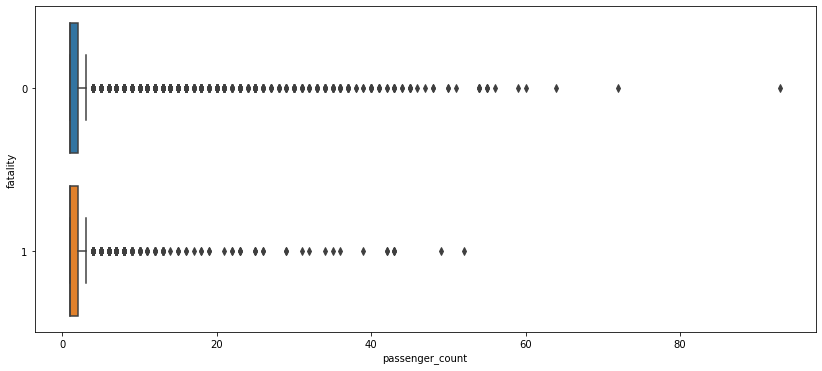

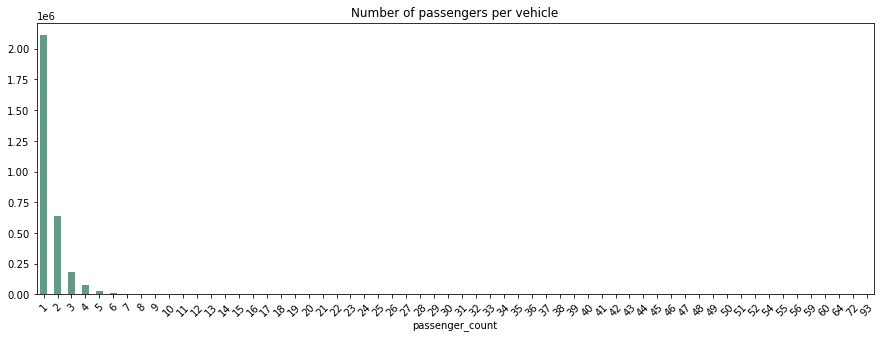

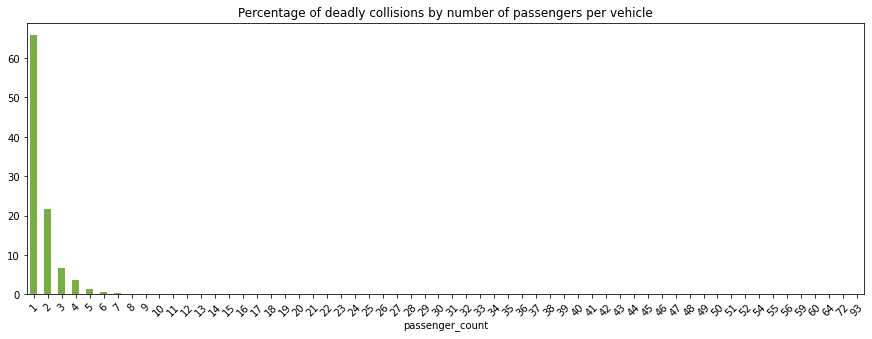

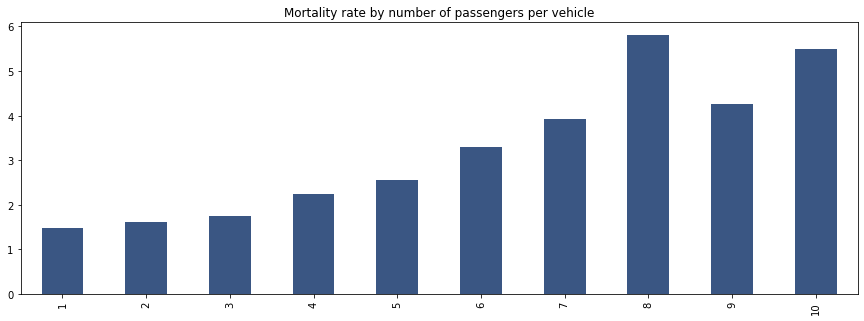

In [69]:
tipos = sorted(np.int8(df_vehicle['passenger_count'].dropna().unique()))
boxplot_fatality("passenger_count", data=df_vehicle)
frecuencia("passenger_count", tipos, "Number of passengers per vehicle", data=df_vehicle)
mortalidadtotal("passenger_count", tipos, "Percentage of deadly collisions by number of passengers per vehicle", data=df_vehicle)

analysis = df_vehicle.loc[(df_vehicle['passenger_count'] < 11) & (df_vehicle['passenger_count'] >= 0)].groupby(['passenger_count', "fatality"]).size()
serie = list()
for i in range(0, np.int8(len(analysis)/2)):
    serie.append(analysis[:,1].iloc[[i]].item() / (analysis[:,1].iloc[[i]].item() + (analysis[:,0].iloc[[i]].item())) * 100)
analysis = pd.Series(serie, index = range(0, np.int8(len(analysis)/2)))
plt.figure(figsize=(15,5))
plot = analysis.plot(kind="bar", title = "Mortality rate by number of passengers per vehicle", color= "#3A5683").set_xticklabels(list(range(1,11)))

In [70]:
# Mortalidad por accidente reportado 
fatality_per = df_accident['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = df_accident['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

In [71]:
#Eliminamos la columna vehicle_id
df.drop('vehicle_id', axis=1, inplace=True)
df_vehicle.drop('vehicle_id', axis=1,inplace=True)

In [72]:
#Guardamos los dataframes 
#conda install -c conda-forge fastparquet
df.to_parquet("../data/full_data_initial.parquet")
df_vehicle.to_parquet("../data/vehicle_data_initial.parquet")
df_accident.to_parquet("../data/aaccident_data_initial.parquet")